# Data Load

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
%matplotlib inline

playing with replacing string values and identifying alternative Nans and dropping all nans.  hope to try some Imputation after I get initial chart working

In [4]:
from sklearn.preprocessing import Imputer
df = pd.read_csv('aps_failure_training_set.csv', na_values='na')
df = df.replace({'neg':0, 'pos':1})
# df = df.dropna()
covs = df
mat = df.as_matrix()

my_imputer = Imputer()
mat = my_imputer.fit_transform(mat)
# mat
# print(mat.shape)
# df

# mat = np.loadtxt('aps_failure_training_set.csv',delimiter=',',skiprows=1)



(60000, 171)


# Plotting for PCA and tSNE

/Users/mmoddrell/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


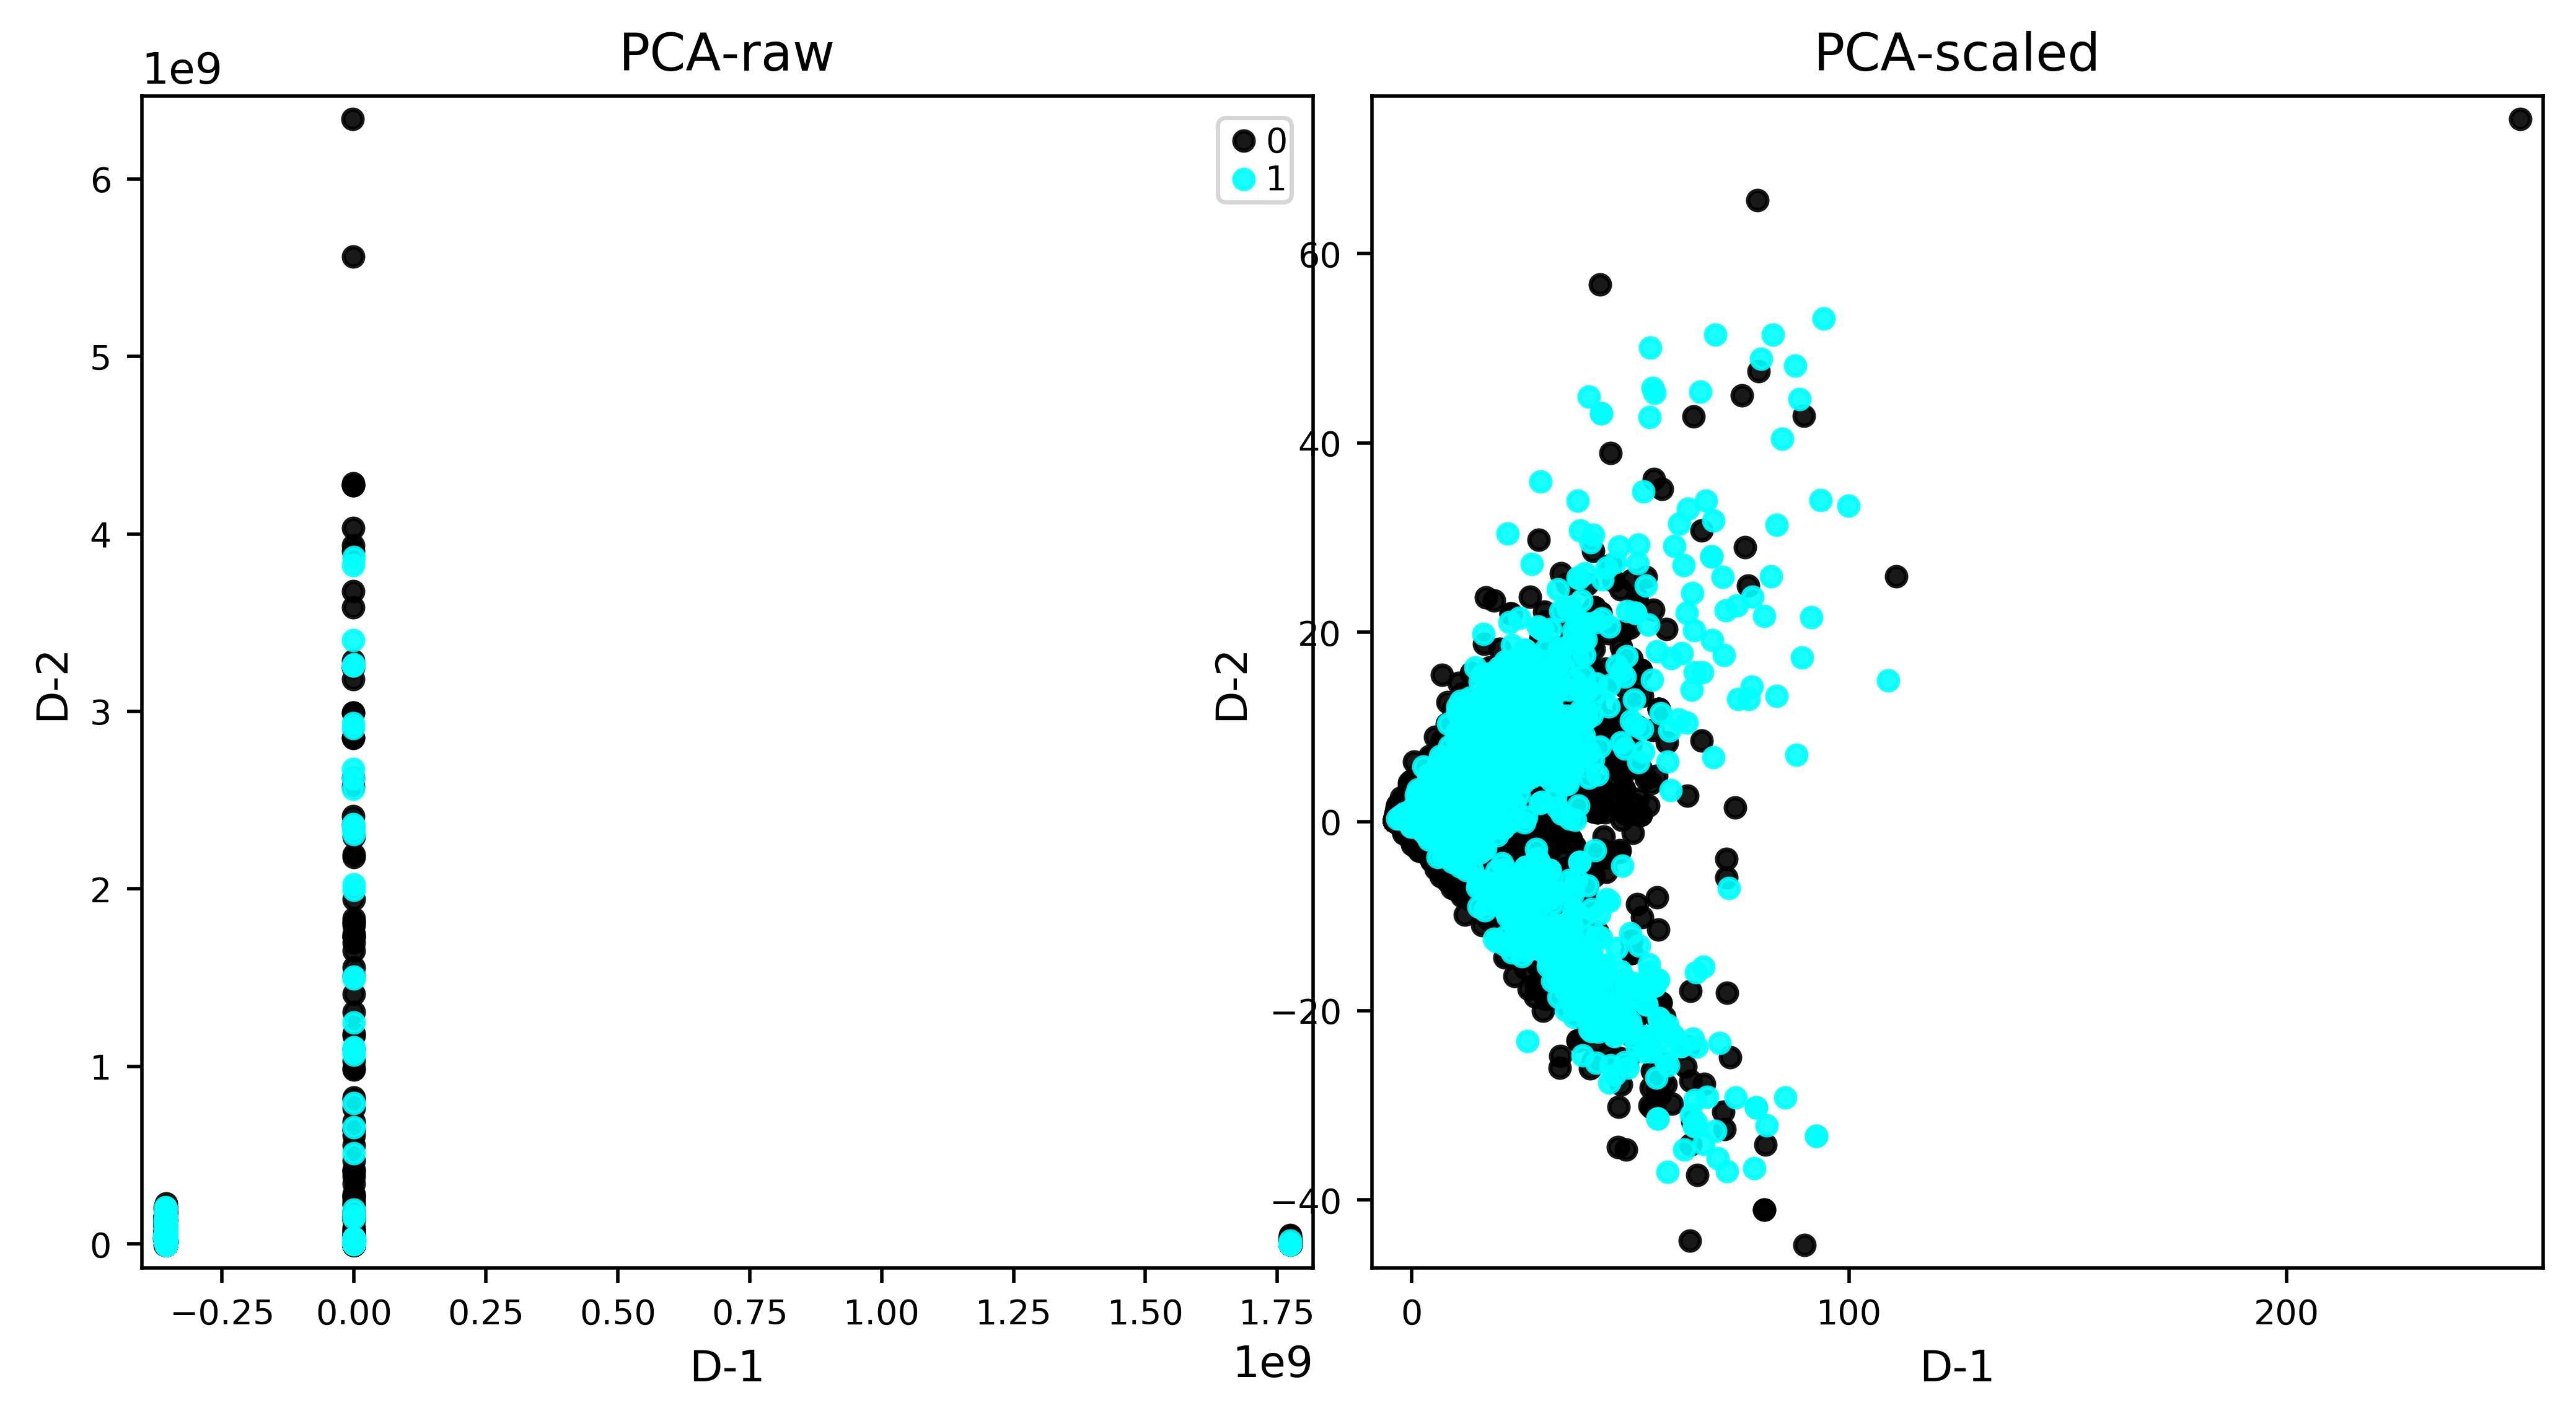

In [5]:
from IPython.display import Image
matScaled = preprocessing.scale(mat)
fit1 = PCA(n_components=2).fit_transform(mat)
fit2 = PCA(n_components=2).fit_transform(matScaled)

def make_subplot(fit,covs,covariate,ax,pcX=0,pcY=1,fontSize=10,fontName='sans serif',ms=20,leg=True,title=None):
    colors = ['k','cyan','r','orange','g','b','magenta']
    cvNames = np.sort(np.unique(covs[covariate]))
    lines = []
    for _i,i in enumerate(cvNames):
        indices = np.where(covs[covariate]==i)[0]
        s = ax.scatter(fit[indices,pcX],fit[indices,pcY],c=colors[_i],s=ms,label=covariate,alpha=0.9)
        lines.append(s)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)

    buff = 0.02
    bufferX = buff * (fit[:,pcX].max() - fit[:,pcX].min())
    bufferY = buff * (fit[:,pcY].max() - fit[:,pcY].min())
    ax.set_xlim([fit[:,pcX].min()-bufferX,fit[:,pcX].max()+bufferX])
    ax.set_ylim([fit[:,pcY].min()-bufferY,fit[:,pcY].max()+bufferY])
    ax.set_xlabel("D-%s"%str(pcX+1),fontsize=fontSize,fontname=fontName)
    ax.set_ylabel("D-%s"%str(pcY+1),fontsize=fontSize,fontname=fontName)
    plt.locator_params(axis='x',nbins=5)
    ax.set_aspect(1./ax.get_data_ratio())
         
    if title:
        ax.set_title(title,fontsize=fontSize+2,fontname=fontName)
    if leg:
        legend = ax.legend(lines,cvNames,loc='upper right',scatterpoints=1,
                           handletextpad=0.01,labelspacing=0.01,borderpad=0.1,handlelength=1.0)

        for label in legend.get_texts():
            label.set_fontsize(fontSize-2)
            label.set_fontname(fontName)
            
plt.clf()
fig = plt.figure(figsize=(10,8),dpi=500)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

make_subplot(fit1,covs,'class',ax1,pcX=0,pcY=1,leg=True,title='PCA-raw')
make_subplot(fit2,covs,'class',ax2,pcX=0,pcY=1,leg=False,title='PCA-scaled')
plt.subplots_adjust(hspace=0.3,wspace=0.05);
#plt.savefig("outliers-projection.png",dpi=600);

# Run Outlier Algorithm

/Users/mmoddrell/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[False  True  True ..., False False False]


ValueError: Contour levels must be increasing

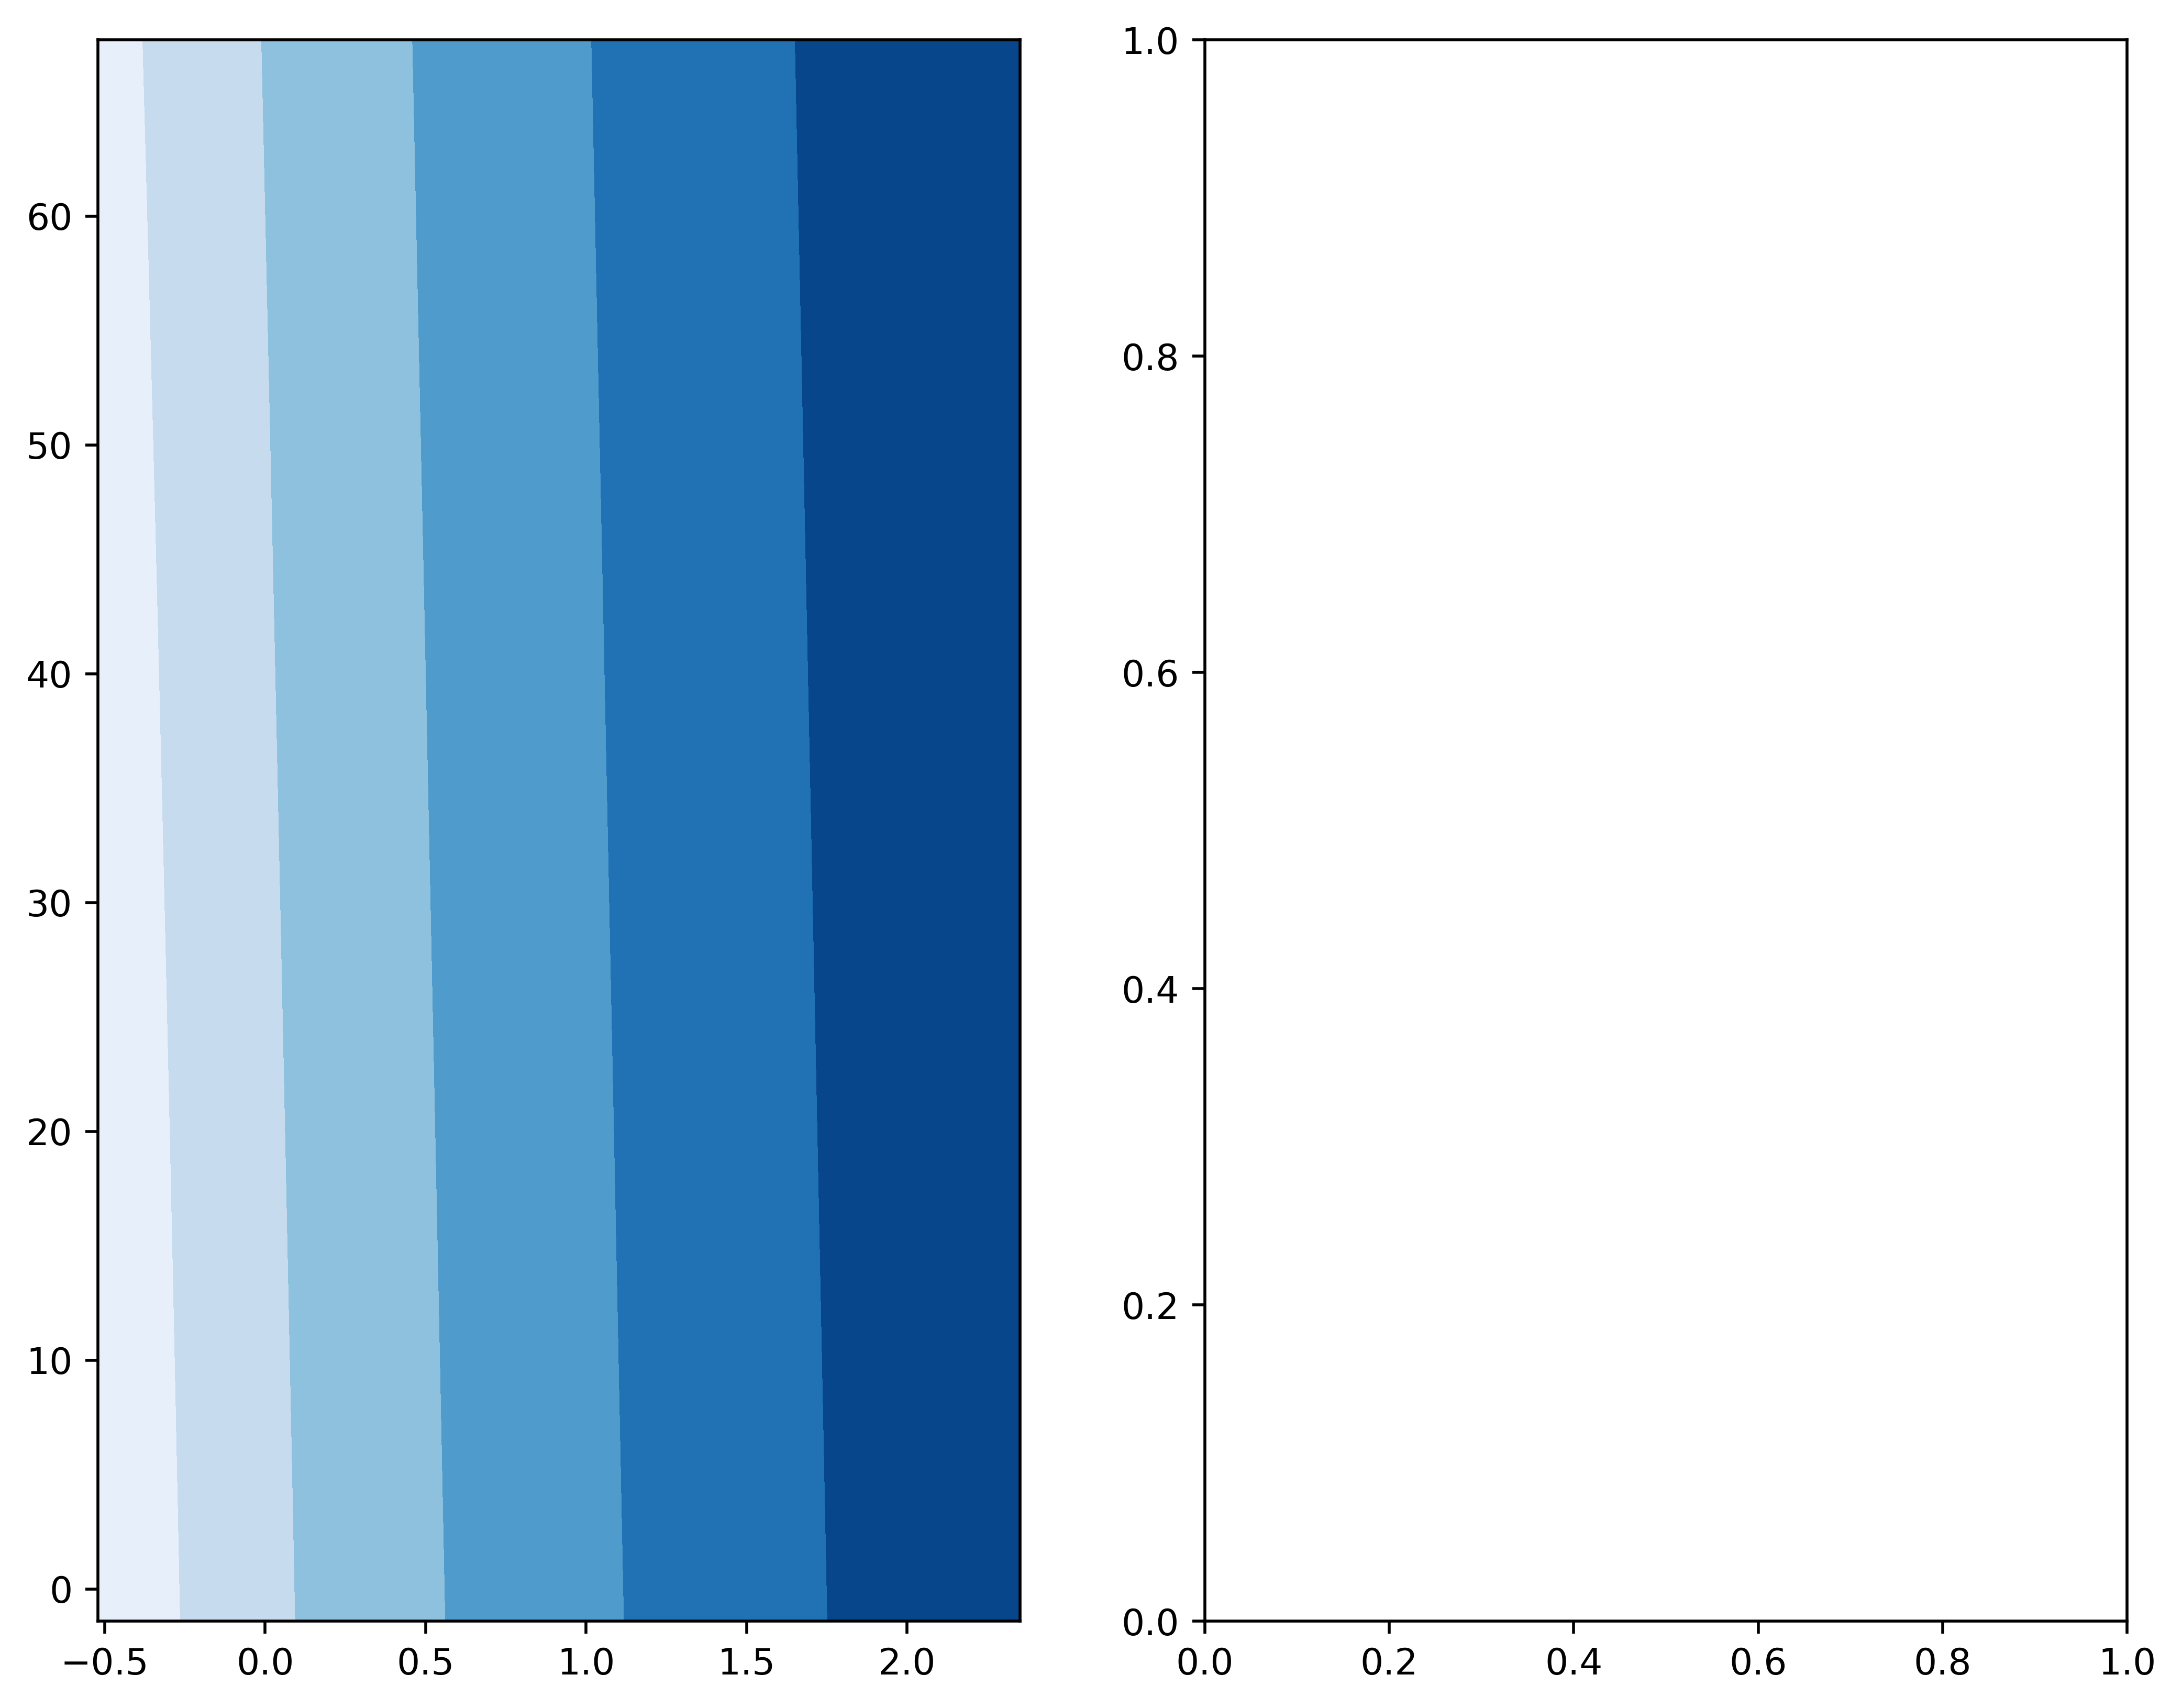

In [7]:
from IPython.display import Image
outliers_fraction = 0.5
classifiers = {"robust covariance estimator": EllipticEnvelope(contamination=outliers_fraction)}

def make_subplot_again(X,covs,covariate,ax,pcX=0,pcY=1,fontSize=10,fontName='sans serif',ms=20,leg=True,title=None):

    ## variables
    colors = ['k','cyan','r','orange','g','b','magenta']
    clf_name = "robust covariance estimator"
    clf = EllipticEnvelope(contamination=.1)
    X =preprocessing.scale(X.copy())
    
    ## figure out scale
    buff = 0.02
    bufferX = buff * (X[:,pcX].max() - X[:,pcX].min())
    bufferY = buff * (X[:,pcY].max() - X[:,pcY].min())
    mm = [(X[:,pcX].min()-bufferX,X[:,pcX].max()+bufferX),(X[:,pcY].min()-bufferY,X[:,pcY].max()+bufferY)]
    xx, yy = np.meshgrid(np.linspace(mm[0][0],mm[0][1], 500), np.linspace(mm[1][0],mm[1][1],500))
    
    # fit the data and tag outliers
    clf.fit(X)
    y_pred = clf.decision_function(X).ravel()
    threshold = stats.scoreatpercentile(y_pred,100 * outliers_fraction)
    
    y_pred = y_pred > threshold
    print(y_pred)
    
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    a = ax.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    ax.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    ax.axis('tight')
   
    cvNames = np.sort(np.unique(covs[covariate]))
    lines = []
    for _i,i in enumerate(cvNames):
        indices = np.where(covs[covariate]==i)[0]
        s = ax.scatter(X[indices,pcX],X[indices,pcY],c=colors[_i],s=ms,label=covariate,alpha=0.9)
        lines.append(s)

    ## axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)

    ax.set_xlabel("D-%s"%str(pcX+1),fontsize=fontSize,fontname=fontName)
    ax.set_ylabel("D-%s"%str(pcY+1),fontsize=fontSize,fontname=fontName)
    plt.locator_params(axis='x',nbins=5)
    ax.set_aspect(1./ax.get_data_ratio())
    ax.set_xlim(mm[0])
    ax.set_ylim(mm[1])
 
    if title:
        ax.set_title(title,fontsize=fontSize+2,fontname=fontName)
    if leg:
        legend = ax.legend(lines,cvNames,loc='upper right',scatterpoints=1,
                           handletextpad=0.01,labelspacing=0.01,borderpad=0.1,handlelength=1.0)

        for label in legend.get_texts():
            label.set_fontsize(fontSize-2)
            label.set_fontname(fontName)

## make the figure again
plt.clf()
fig = plt.figure(figsize=(10,8),dpi=500)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
make_subplot_again(fit1,covs,'class',ax1,pcX=0,pcY=1,leg=True,title='PCA-raw')
make_subplot_again(fit2,covs,'class',ax2,pcX=0,pcY=1,leg=False,title='PCA-scaled')
plt.subplots_adjust(hspace=0.1,wspace=0.2)
#plt.savefig("outliers-detection.png",dpi=600)
